In [68]:
from ce3_compare import set_name, compare, write_submission_txt, grade, set_idm
from feature_model import FeatureModel
import numpy as np

In [69]:
set_name("S M Abdul", "Ahad")
set_idm("ys15ciaz")

# Computer exercise 3 (Global post-hoc methods)

- Partial dependence plots (PDP)
- Individual conditional expectation (ICE) <- *local*
- M-Plot
- Accumulated local effects (ALE)
- Permutation feature importance

<img src="pdp_ice_mplot_ale.png" width="1200"/>

## Partial dependence plots (PDP)

In [70]:
bike_path = "datasets/bike/rented_bikes_day_pre.csv"
bike_data = FeatureModel(bike_path)
bike_data.df = bike_data.df.drop(labels=["casual", "registered"], axis=1)
bike_data.add_target("cnt")
bike_data.add_all_features_but_target()

FeatureModel(->Not fully specified yet!)
FeatureModel(cnt ~ -1 + season + yr + mnth + holiday + weekday + workingday + weathersit + temp + hum + windspeed + days_since_01_01_2011 )


In [71]:
X,y = bike_data.return_Xy(train_test_split=False)

In [72]:
from sklearn.inspection import PartialDependenceDisplay

def pdp_plot(m, X_train, y_train, X_val=None, kind="average", features=["temp","hum","windspeed"]):
    if X_val is None:
        X_val = X_train
        
    m.fit(X_train, y_train)
    print("R2-score: ", m.score(X_train, y_train))

    pdp = PartialDependenceDisplay.from_estimator(
        m,
        X_val,
        features,
        kind=kind, grid_resolution=100, percentiles=(0,1), method="brute",
        **(dict(pd_line_kw=dict(color="red")) if kind == "both" else {})
    )

    for ax in pdp.axes_[0,:]:
        ax.grid(True)


### PDP for Linear Regression

R2-score:  0.8003086666446174


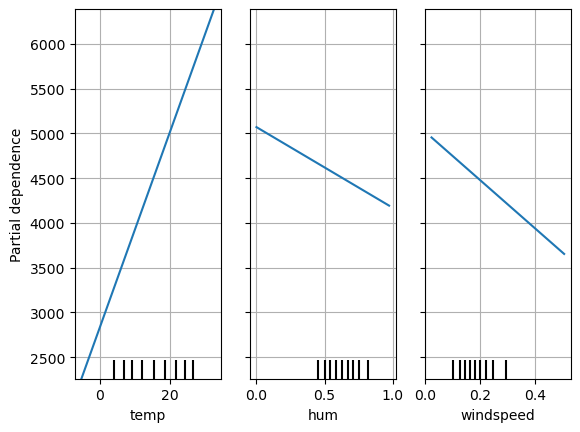

In [73]:
from sklearn.linear_model import LinearRegression

pdp_plot(LinearRegression(), X, y)

Q: What is the meaning of the y-axis in the PDP plot?

Q: What is the meaning of the y-axis for classification?

Q: Does it make sense to create a PDP plot for a LinearRegression?

Q: Does it make sense to create a PDP plot for any inherently explainable model?

### PDP for RandomForestRegressor

C:\Users\ALIF\AppData\Local\Temp\ipykernel_15352\3605117797.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


R2-score:  0.9835492651632314


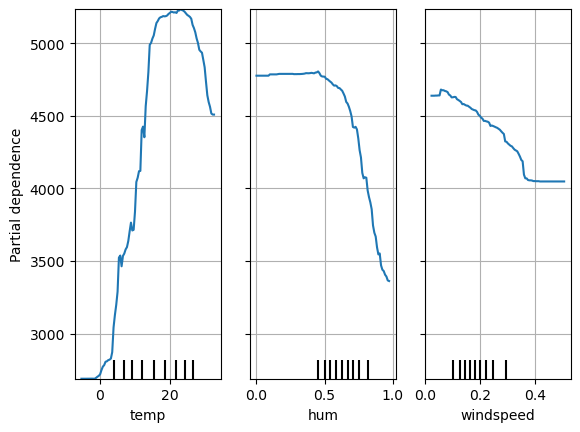

In [74]:
from sklearn.ensemble import RandomForestRegressor

pdp_plot(RandomForestRegressor(), X, y)

### PDP for AdaBoost

F:\Anaconda\Anaconda3\envs\xML\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R2-score:  0.8531967783409402


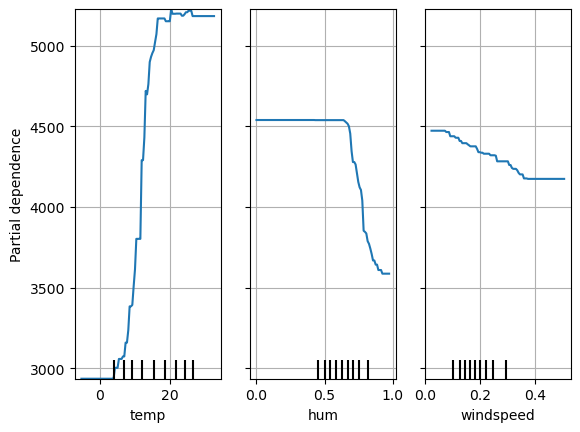

In [75]:
from sklearn.ensemble import AdaBoostRegressor

pdp_plot(AdaBoostRegressor(), X, y)

Q: Does it make sense to use validation data for the averaging?

Q: If you want to explain your model's behaviour, would you use all data / only training data / only validation data?

In [76]:
X_train, y_train, X_val, y_val = bike_data.return_Xy(train_test_split=True)

C:\Users\ALIF\AppData\Local\Temp\ipykernel_15352\3605117797.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


R2-score:  0.9818969679639621


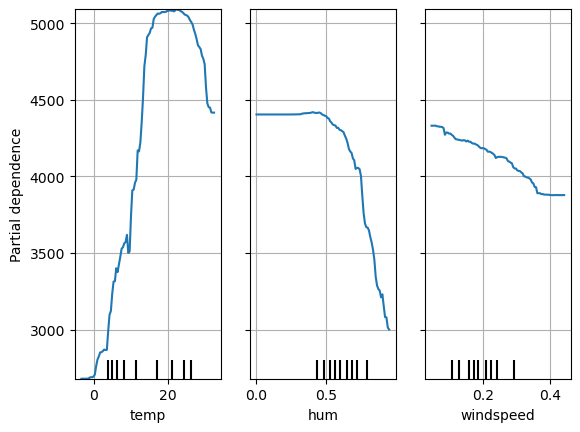

In [77]:
pdp_plot(RandomForestRegressor(), X_train, y_train, X_val)

### Exercise 3.1

Use a `RandomForestRegressor` with `random_state`=1 to predict the number of rented bikes. What is the $\Delta y$ in the last/directly above PDP-plot for the `temp` feature between $20^\circ$ and $0^\circ$? Write a function that returns that exact value.

In [78]:
def ex_3_1() -> float:
    regr = RandomForestRegressor(random_state=1)
    regr.fit(X_train, y_train.values.ravel()) #fitting and flatting column vector y into 1-D vector as 
    
    xval = X_val.copy()

    xval['temp'] = 20
    temp_20 = regr.predict(xval).mean() #Predicted mean value for temp 20
    
    xval['temp'] = 0
    temo_0 = regr.predict(xval).mean() #Predicted mean value for temp 0
    
    delta_y = temp_20 -temo_0
    
    return delta_y

In [79]:
ex_3_1()

2354.0546938775506

In [80]:
compare("ex_3_1", ex_3_1)

Great work!


### Exercise 3.2

In the last/directly above PDP-plot for the `windspeed` feature on the x-axis, on which windspeed value is exactly the 5th vertical line? Write a function that returns that exact value.

In [81]:
def ex_3_2() -> float:
    return X_val['windspeed'].median() 


In [82]:
ex_3_2()

0.185312

In [83]:
compare("ex_3_2", ex_3_2)

There must be at least one second downtime between `compare` calls


### PDP for classification

In [84]:
cancer_path = "datasets/cervical_cancer/risk_factors_cervical_cancer_pre.csv"
cancer_data = FeatureModel(cancer_path)
cancer_data.add_target("Biopsy")
cancer_data.add_all_features_but_target()
X_train, y_train, X_val, y_val = cancer_data.return_Xy(train_test_split=True)

FeatureModel(->Not fully specified yet!)
FeatureModel(Biopsy ~ -1 + Age + Number_of_sexual_partners + First_sexual_intercourse + Num_of_pregnancies + Smokes + Smokes__years + Hormonal_Contraceptives + Hormonal_Contraceptives__years + IUD + IUD__years + STDs + STDs__Number_of_diagnosis + STDs__Time_since_first_diagnosis + STDs__Time_since_last_diagnosis )


F:\Anaconda\Anaconda3\envs\xML\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R2-score:  0.9373177842565598


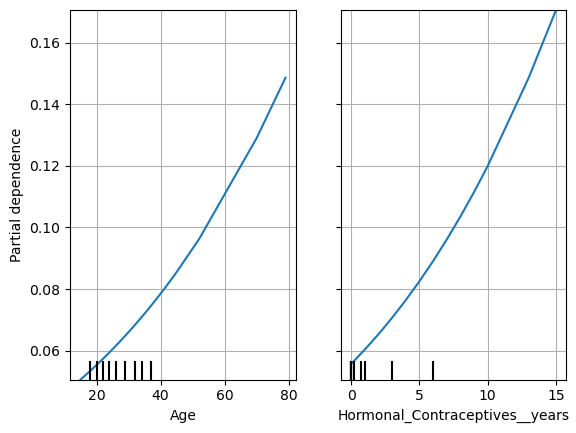

In [85]:
from sklearn.linear_model import LogisticRegression

pdp_plot(LogisticRegression(max_iter=1000), X_train, y_train, X_val=X_val, features=["Age", "Hormonal_Contraceptives__years"])

C:\Users\ALIF\AppData\Local\Temp\ipykernel_15352\3605117797.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


R2-score:  0.9970845481049563


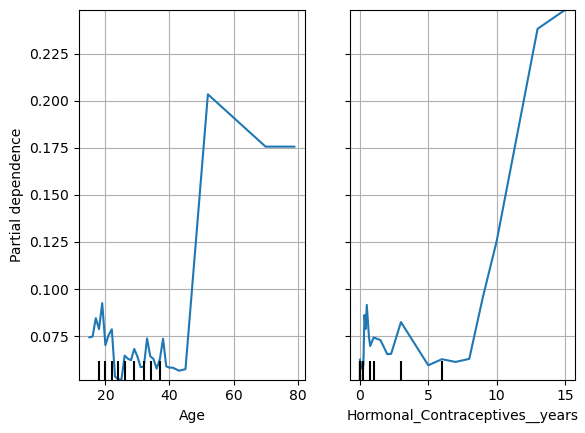

In [86]:
from sklearn.ensemble import RandomForestClassifier
pdp_plot(RandomForestClassifier(), X_train, y_train, X_val=X_val, features=["Age", "Hormonal_Contraceptives__years"])

C:\Users\ALIF\AppData\Local\Temp\ipykernel_15352\3605117797.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


R2-score:  0.9970845481049563


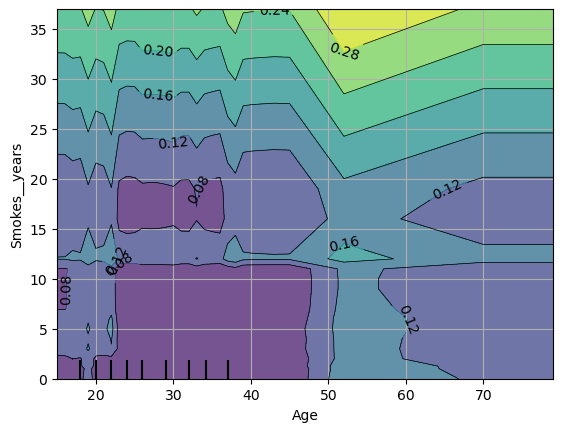

In [87]:
pdp_plot(RandomForestClassifier(), X_train, y_train, X_val=X_val, features=[["Age", "Smokes__years"]])

Q: Does this plot imply that smoking increases the cancer probability regardless of age? Take a close look at the upper-left corner

## Individual conditional expectation (ICE) <- local

C:\Users\ALIF\AppData\Local\Temp\ipykernel_15352\3605117797.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


R2-score:  0.9970845481049563


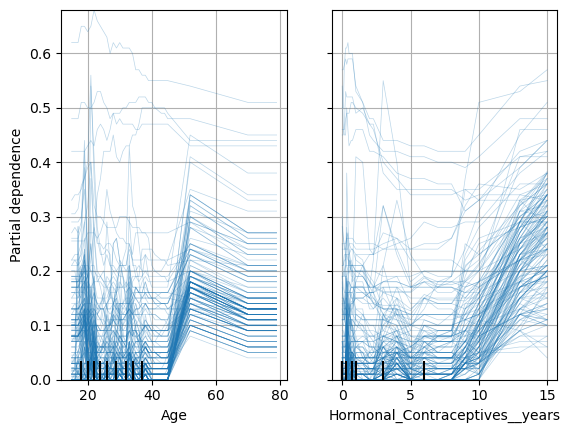

In [88]:
pdp_plot(RandomForestClassifier(random_state=1), X_train, y_train, X_val=X_val, features=["Age", "Hormonal_Contraceptives__years"], kind="individual")

C:\Users\ALIF\AppData\Local\Temp\ipykernel_15352\3605117797.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


R2-score:  0.9970845481049563


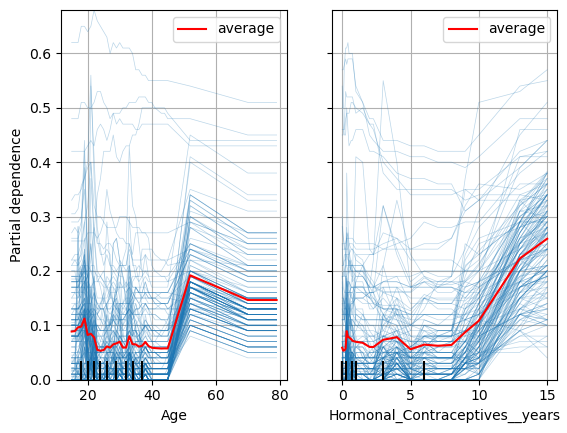

In [89]:
pdp_plot(RandomForestClassifier(random_state=1), X_train, y_train, X_val=X_val, features=["Age", "Hormonal_Contraceptives__years"], kind="both")

### Exercise 3.3

Use a `RandomForestClassifier(random_state=1)`.
What is the predicted cancer probability with an Age of sixty years according to the datapoint with the highest predicted cancer probability of the validation dataset?
Write a function that returns that value.

In [90]:
def ex_3_3() -> float:
    randcls = RandomForestClassifier(random_state=1)
    randcls.fit(X_train, y_train.values.ravel()) #  fitting and flatting column vector y into 1-D vector as 
    
    xval = X_val.copy()
    #print(xval)
    xval['Age'] = 60
    #highest_pred_60 = randcls.predict_proba(xval)
    
    prediction = randcls.predict(xval)

    index_60 = 0
    for ind, n in np.ndenumerate(prediction):
        if n == 1:
            index_60 = ind
            probability = randcls.predict_proba(xval)
            highest_pred_60 = probability[index_60][1]
    
    return highest_pred_60 # Definitely between 0.5 and 0.7, see plot directly above



In [91]:
ex_3_3()

0.52

In [92]:
compare("ex_3_3", ex_3_3)

Great work!


## Accumulated local effects (ALE)

In [93]:
from PyALE import ale # <- This really is more of an m-plot

In [94]:
X,y = bike_data.return_Xy()
regr = RandomForestRegressor(random_state=1)
regr.fit(X,y)

C:\Users\ALIF\AppData\Local\Temp\ipykernel_15352\890520154.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X,y)


RandomForestRegressor(random_state=1)

PyALE._ALE_generic:INFO: Continuous feature detected.


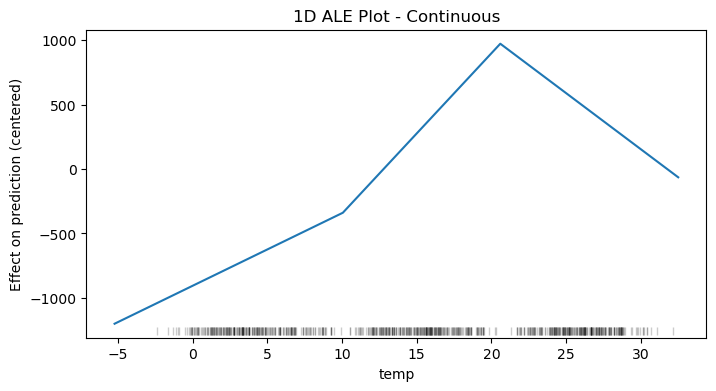

In [95]:
ale_eff = ale(X, regr, ["temp"], grid_size=3, include_CI=False,)

In [96]:
ale_eff

,eff,size
temp,,
-5.220871,-1200.381206,0.0
10.055849,-338.901575,244.0
20.591651,972.902278,244.0
32.498349,-63.894759,243.0


PyALE._ALE_generic:INFO: Continuous feature detected.


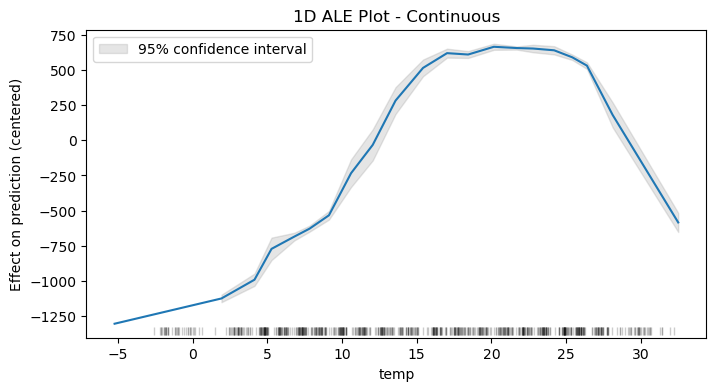

In [97]:
ale_eff = ale(X, regr, ["temp"], grid_size=20, include_CI=True, C=0.95)

In [98]:
ale_eff.reset_index()

,temp,eff,size,lowerCI_95%,upperCI_95%
0,-5.220871,-1304.437601,0.0,NaN,NaN
1,1.931288,-1124.719223,37.0,-1151.469293,-1097.969152
2,4.141651,-991.390612,36.0,-1035.050161,-947.731062
3,5.282623,-771.891422,37.0,-851.772184,-692.010661
4,6.805000,-684.808922,36.0,-712.302558,-657.315286
5,7.823349,-628.386760,37.0,-649.767757,-607.005763
6,9.124356,-533.140371,36.0,-563.883810,-502.396933
7,10.604151,-233.696858,37.0,-332.230836,-135.162880
8,12.053349,-32.454636,36.0,-143.061396,78.152125
9,13.580849,282.745635,37.0,187.392936,378.098333


### Exercise 3.4

For what *lower* temperature is the expectation of the centered effect on the predicted number of rented bikes exactly zero?
(You may use the table directly above)

In [99]:
def ex_3_4() -> float:
    ale_eff_temp = ale_eff.reset_index()
    
    lower_temp = ale_eff_temp['temp'][8] 
    higher_temp = ale_eff_temp['temp'][9]
    
    lower_eff = ale_eff_temp['eff'][8]
    higher_eff = ale_eff_temp['eff'][9]
    
    slope = (higher_eff-lower_eff) / (higher_temp-lower_temp)
    
    CenterEffect_0 = lower_temp + (0-lower_eff)/slope
    
    return CenterEffect_0


In [100]:
ex_3_4()

12.210628229981651

In [101]:
compare("ex_3_4", ex_3_4)

Great work!


### Exercise 3.5 (harder)

Using the above table, what is the 95%-confidence interval of the effect delta when going from `temp=1.931288` to `temp=4.141651`?

*Hint 1*: The 95%-confidence intervall for a normal distribution is at $1.96$ standard deviations

*Hint 2*: https://en.wikipedia.org/wiki/Sum_of_normally_distributed_random_variables

In [102]:
import math
def ex_3_5() -> (float, float):
    
    effect_delta = abs(-1124.719223 - (-991.390612))
    var1= math.pow(((-1097.969152 - (-1151.469293)) / (2 * 1.96)), 2)
    var2 = math.pow(((-947.731062 - (-1035.050161)) / (2 * 1.96)), 2)
    stndr_dev = math.sqrt(var1 + var2)
    
    lower_bound = effect_delta - 1.96 * stndr_dev
    upper_bound = effect_delta + 1.96 * stndr_dev
    return (lower_bound, upper_bound)

In [103]:
ex_3_5()

(82.12585195033628, 184.53137004966376)

In [104]:
compare("ex_3_5", ex_3_5)

There must be at least one second downtime between `compare` calls


## Permutation feature importance

Features that are deemed of low importance for a bad model (low cross-validation score) could be very important for a good model. Therefore it is always important to evaluate the predictive power of a model using a held-out set (or better with cross-validation) prior to computing importances. Permutation importance does not reflect to the intrinsic predictive value of a feature by itself but *how important this feature is for a particular model*.


In [105]:
from sklearn.inspection import permutation_importance

In [106]:
X_train, y_train, X_val, y_val = bike_data.return_Xy(train_test_split=True)

In [107]:
from sklearn.ensemble import GradientBoostingRegressor
regr = GradientBoostingRegressor(random_state=1)
regr.fit(X_train, y_train)
regr.score(X_val, y_val)

F:\Anaconda\Anaconda3\envs\xML\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9021025738192169

In [108]:
r = permutation_importance(regr, X_val, y_val, n_repeats=20, random_state=1)

In [109]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_val.columns[i]:<22} | "
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

days_since_01_01_2011  | 0.711 +/- 0.047
temp                   | 0.459 +/- 0.034
hum                    | 0.050 +/- 0.010
windspeed              | 0.030 +/- 0.009
weathersit             | 0.016 +/- 0.007
season                 | 0.011 +/- 0.004
mnth                   | 0.008 +/- 0.003
workingday             | 0.007 +/- 0.002


### Exercise 3.6

Using a `GradientBoostingClassifier(random_state=1)` and `permutation_importance(..., n_repeats=20, random_state=1)`. What is the most important feature of in the cervical cancer dataset?
Write a function that returns this column name.

In [110]:
from sklearn.ensemble import GradientBoostingClassifier

def ex_3_6() -> str:
    X_train, y_train, X_val, y_val = cancer_data.return_Xy(train_test_split=True)
    
    gboost_clf = GradientBoostingClassifier(random_state=1)
    gboost_clf.fit(X_train, y_train.values.ravel())
    
    res = permutation_importance(gboost_clf, X_val, y_val, n_repeats=20, random_state=1)
    mif_ind = res.importances_mean.argmax()
    
    return X_val.columns[mif_ind]


In [111]:
ex_3_6()

'First_sexual_intercourse'

In [112]:
compare("ex_3_6", ex_3_6)

Great work!


Q: Argue why you might question this result?

Q: Repeat `ex_3_6` with a `RandomForestClassifier` instead. What is now the result?

In [113]:
from ce3_compare import scores

In [114]:
scores

{'ex_3_1': True,
 'ex_3_2': True,
 'ex_3_3': True,
 'ex_3_4': True,
 'ex_3_5': True,
 'ex_3_6': True}

In [115]:
write_submission_txt()

In [116]:
grade("ce3_S M Abdul_Ahad.txt")

'100.0% are correct'